# **Data Collection Notebook**

## Objectives

* Fetch dataset from Kaggle.
* Preliminary data exploration
* Save dataset in the appropriate format.

## Inputs

* Synthetic hospital records by MIT.

## Outputs

* Generate Dataset: outputs/datasets/collection/patientReadmission.csv



---

# Set working directory

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
current_dir = os.getcwd()
current_dir

'/workspaces/patient-readmission-predictor'

In [2]:
# Disable warnings:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---

# Load Collected Data

In [3]:
import pandas as pd

df = pd.read_csv("outputs/datasets/collection/patientReadmission.csv")
df.head(5)

,hospital_name,Admission_date,hospital_id,hospital_beds_available,occupied_beds,hospital_ward,patient_id,patient_gender,patient_age,patient_race,...,time_slot,doctor_id,doctor_specialty,patient_assigned_doctor,patient_checkin_date,patient_checkout_date,patient_disease,patient_length_of_stay,discharge_status,readmission
0,The Johns Hopkins Hospital,30-01-2024,3946,260,90,Maternity,1421,Female,48,Asian,...,02:34:00 PM,1725,Rheumatology,False,14-07-2024,19-07-2024,Anxiety Disorders,6,Deceased,1
1,The Johns Hopkins Hospital,20-03-2022,7147,250,90,ICU,4922,Male,40,Black,...,04:07:00 PM,7510,Pulmonology or Allergy and Immunology,False,19-07-2024,07/07/2024,Urinary Tract Infection (UTI),2,Deceased,1
2,The Johns Hopkins Hospital,13-07-2021,4174,350,220,Pediatrics,9804,Female,74,Black,...,07:16:00 PM,7137,Neurology,False,20-07-2024,29-06-2024,Hypertension (High Blood Pressure),17,Recovered,0
3,The Johns Hopkins Hospital,26-01-2021,2466,190,350,Pediatrics,5622,Male,82,Hispanic,...,07:27:00 AM,8801,Cardiology,False,25-06-2024,16-07-2024,Arthritis,28,Recovered,0
4,The Johns Hopkins Hospital,06/02/2024,3014,220,390,Surgery,3314,Male,62,Hispanic,...,01:54:00 PM,3588,Rheumatology,False,21-07-2024,19-07-2024,Cancer,16,Transferred,1


# DataFrame Exploration

Check for columns with missing values

In [4]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

[]

# Correlation and PPS Analysis

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

**Calculate correlations and PPS**

In [6]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean   std  min  25%  50%  75%    max
ppscore  506.0  0.001  0.01  0.0  0.0  0.0  0.0  0.223


In [7]:
df_corr_pearson

,hospital_id,hospital_beds_available,occupied_beds,patient_id,patient_age,patient_sat_score,patient_waittime,doctor_id,patient_assigned_doctor,patient_length_of_stay,readmission
hospital_id,1.000000,-0.005482,-0.015575,-0.025845,-0.018525,-0.024723,-0.002516,-0.004462,0.019495,-0.008151,-0.012493
hospital_beds_available,-0.005482,1.000000,-0.012587,0.011348,0.010908,-0.015711,0.010332,-0.019064,0.005663,0.011894,-0.015347
occupied_beds,-0.015575,-0.012587,1.000000,0.001179,0.009192,0.001081,-0.012195,0.006553,-0.009453,0.009847,-0.002832
patient_id,-0.025845,0.011348,0.001179,1.000000,-0.008449,-0.009493,0.001167,-0.004045,-0.010147,-0.002808,0.011306
patient_age,-0.018525,0.010908,0.009192,-0.008449,1.000000,-0.001767,0.007857,0.008547,-0.005945,0.010378,0.007953
patient_sat_score,-0.024723,-0.015711,0.001081,-0.009493,-0.001767,1.000000,-0.022907,-0.006941,0.004432,-0.006847,-0.008847
patient_waittime,-0.002516,0.010332,-0.012195,0.001167,0.007857,-0.022907,1.000000,-0.009805,-0.005620,0.002781,-0.007363
doctor_id,-0.004462,-0.019064,0.006553,-0.004045,0.008547,-0.006941,-0.009805,1.000000,0.014381,0.003732,0.016550
patient_assigned_doctor,0.019495,0.005663,-0.009453,-0.010147,-0.005945,0.004432,-0.005620,0.014381,1.000000,-0.005917,-0.014555
patient_length_of_stay,-0.008151,0.011894,0.009847,-0.002808,0.010378,-0.006847,0.002781,0.003732,-0.005917,1.000000,0.000874


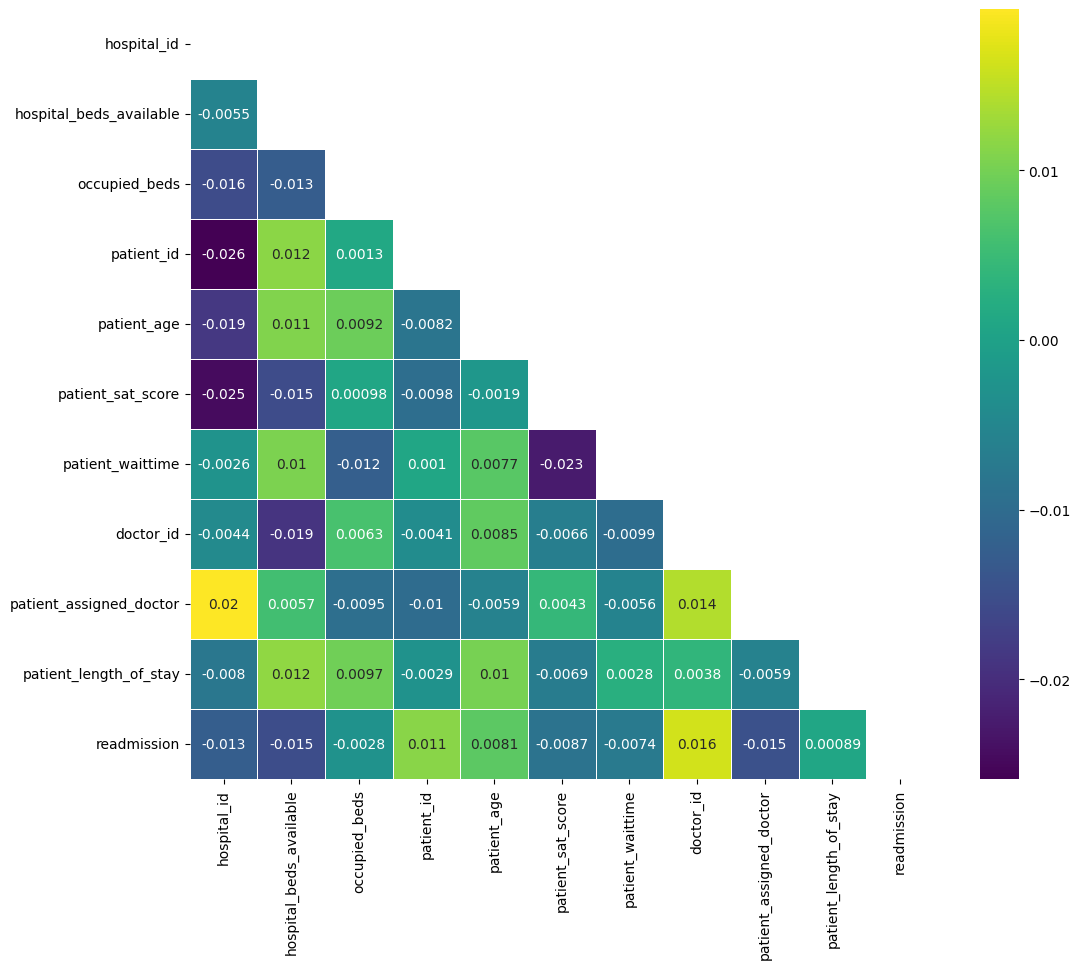

In [8]:
df_corr_spearman
heatmap_corr(df=df_corr_spearman, threshold=0, figsize=(12,10), font_annot=10)

In [9]:
pps_matrix

x,Admission_date,department_referral,discharge_status,doctor_id,doctor_specialty,hospital_beds_available,hospital_id,hospital_name,hospital_ward,occupied_beds,...,patient_checkout_date,patient_disease,patient_gender,patient_id,patient_length_of_stay,patient_race,patient_sat_score,patient_waittime,readmission,time_slot
y,,,,,,,,,,,,,,,,,,,,,
Admission_date,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
department_referral,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.001223,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001117
discharge_status,0.000000,0.000000,1.000000,0.016156,0.006981,0.000000,0.000000,0.0,0.000000,0.000000,...,0.001261,0.000000,0.000000,0.000000,0.020074,0.000000,0.007323,0.007398,0.000000,0.000000
doctor_id,0.000000,0.000000,0.000424,1.000000,0.000000,0.000000,0.000000,0.0,0.000150,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000603,0.000000
doctor_specialty,0.000102,0.000000,0.000000,0.005130,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.001795,0.000000,0.000000,0.005177,0.000000,0.000000,0.002505
hospital_beds_available,0.000000,0.000893,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hospital_id,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hospital_name,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hospital_ward,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.007483,...,0.003183,0.000000,0.000000,0.001257,0.000000,0.000000,0.000000,0.000000,0.000000,0.001713


**Plot heatmaps**



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



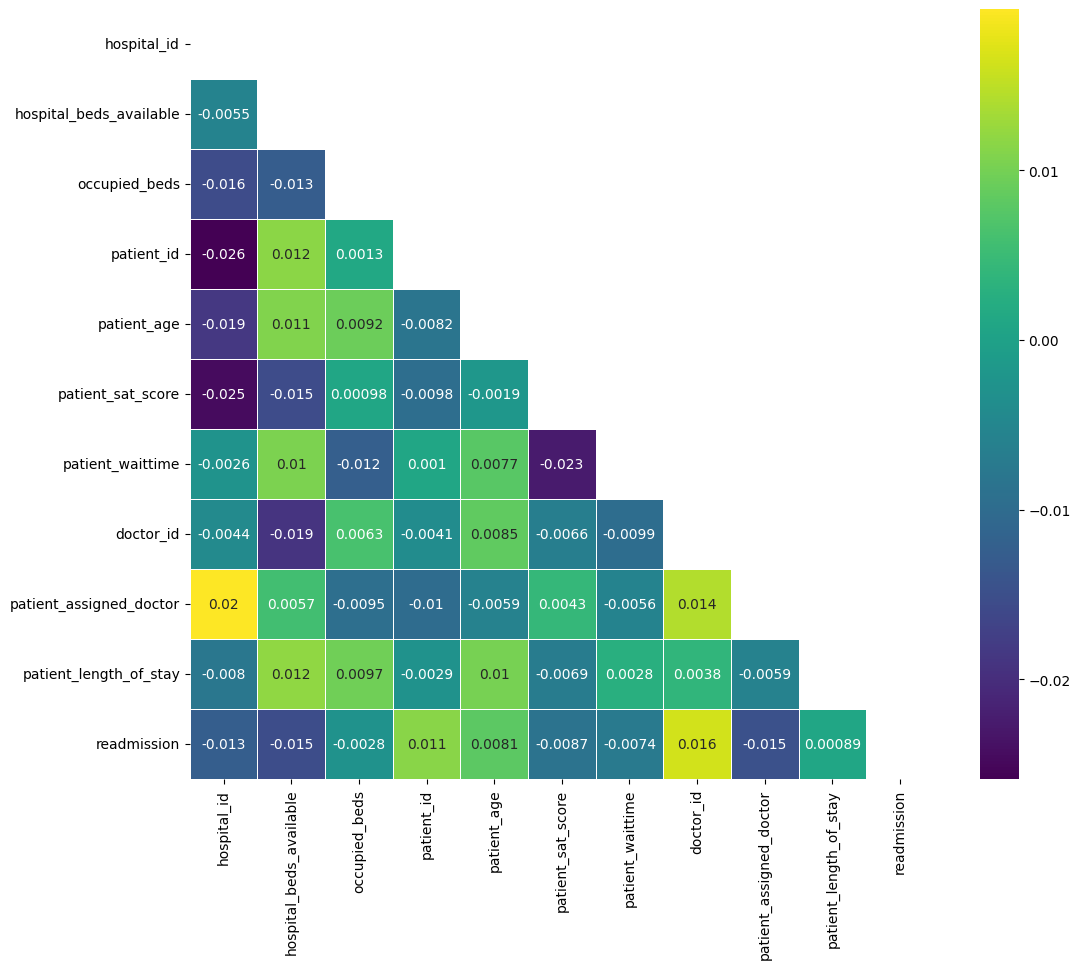



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



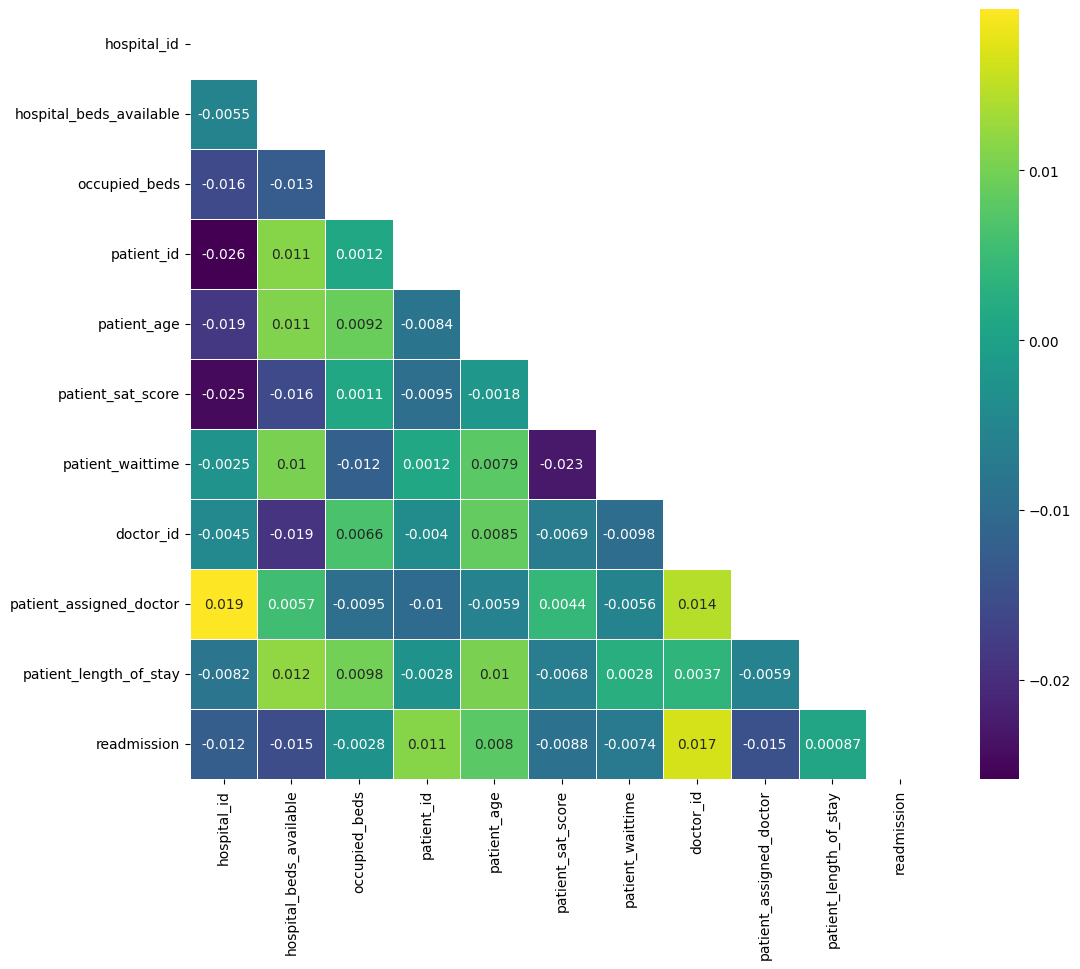



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



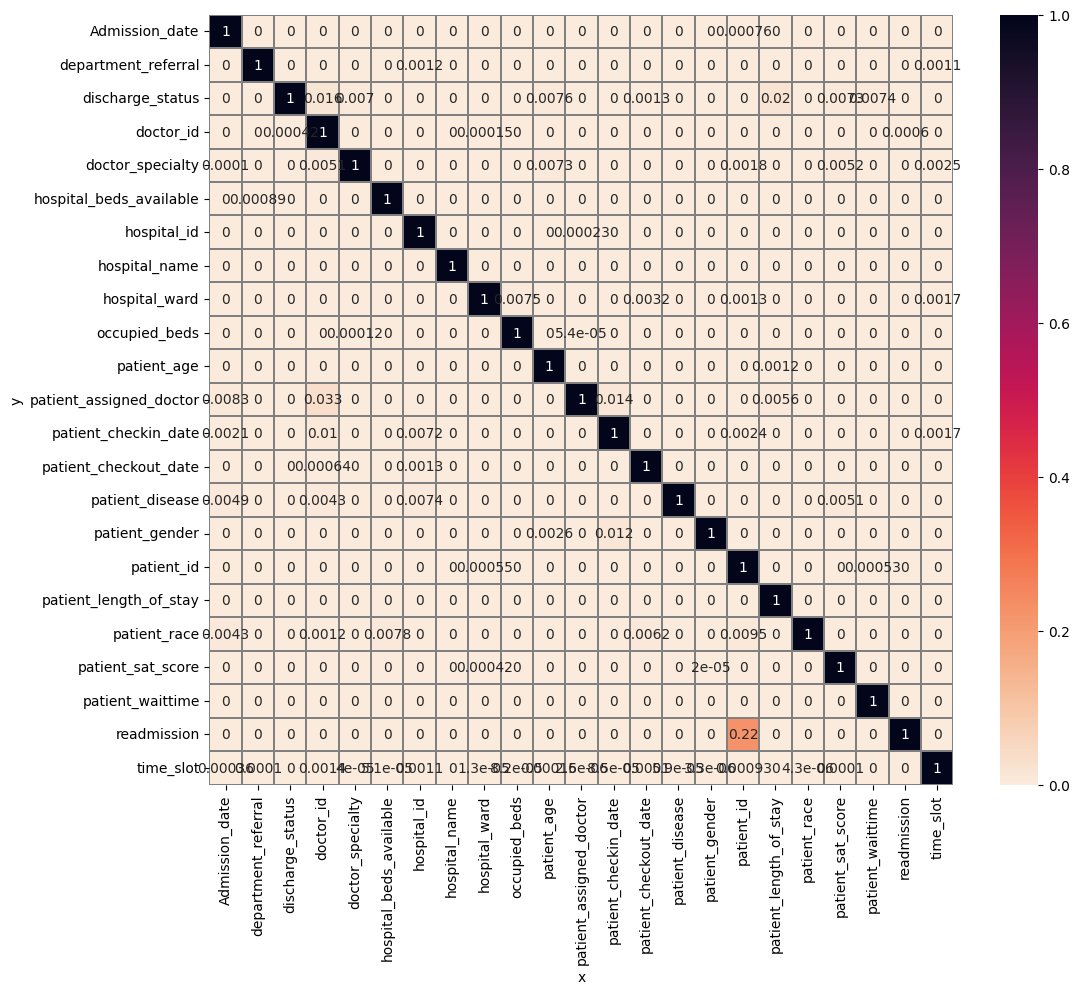

In [10]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0, PPS_Threshold =0,
                  figsize=(12,10), font_annot=10)

# Data Cleaning

## Split Train and Test Set

In [11]:

from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['readmission'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (8000, 23) 
TestSet shape: (2000, 23)


## Drop unused variables (columns)

In [12]:
drop_cols = [
    'hospital_name',
    'hospital_id',
    'patient_id',
]

print(f"* {len(drop_cols)} variables to drop \n\n"
    f"{drop_cols}")

* 3 variables to drop 

['hospital_name', 'hospital_id', 'patient_id']


**Apply imputation to the defined columns in** `drop_cols`

In [13]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=drop_cols)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

# Save Test set and Train set files 

create destination folder: outputs/datasets/cleaned

In [14]:
import os

output_path = r"outputs/datasets/cleaned"
try:
  os.makedirs(name=output_path)
except Exception as e:
  print(e)

## Train Set

In [15]:

TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test Set

In [16]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)

---

# Conclusions and Next Steps

* Week correlations for features and target variable
* Removed unused columns.
* Output file saved to the 'cleaned' subfolder in 'outputs/dataset/'
* Next notebook will `04 - Feature Engineering` focused of feature engineering